In [1]:
# Import all the required libraries
import dask
import dask.dataframe as dd
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from dask.distributed import Client
from IPython.display import SVG

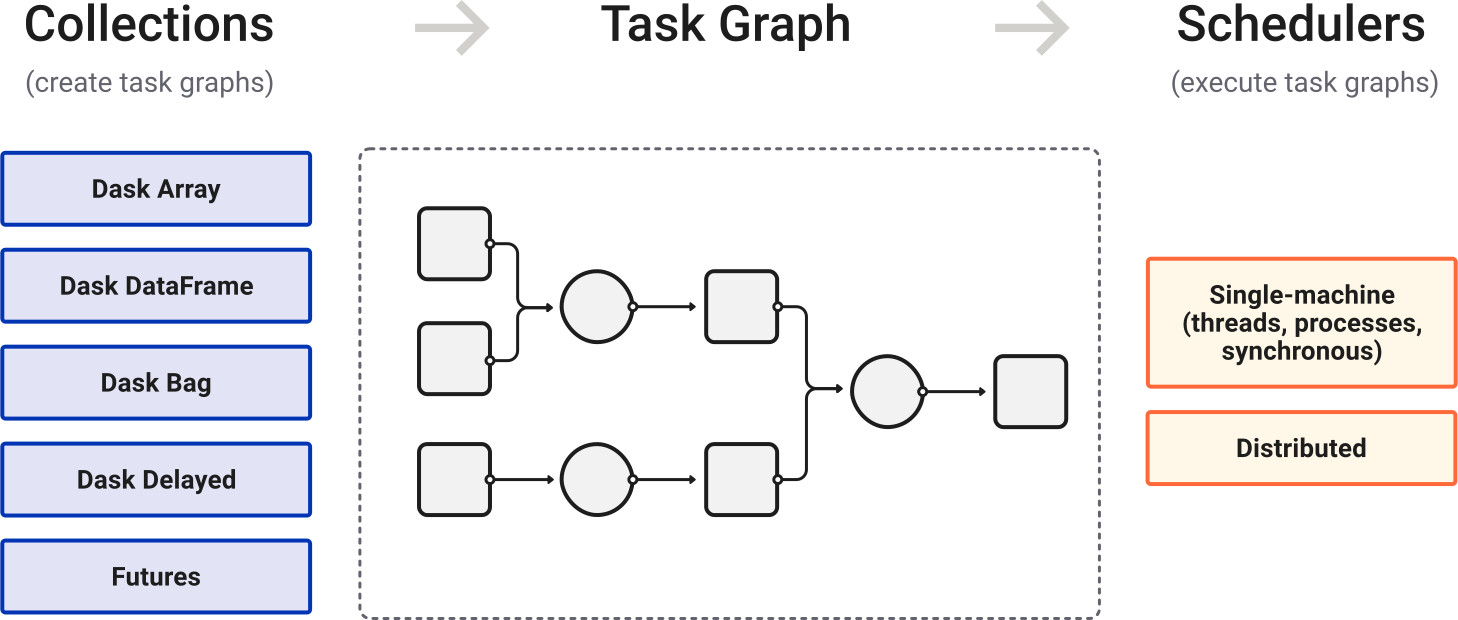

In [2]:
# Dask component overview
SVG(filename='images/dask-overview.svg')

In [3]:
# Function to group by payment type, takes in a dask dataframe as an input that contains the 'payment_type' column
# This will be used for EDA later on in the notebook

def payment_by_type(dask_dataframe:dd=None):
    if dask_dataframe is not None:
        return dask_dataframe.groupby('payment_type').total_amount.sum().compute()
    return None

In [4]:
# Create a Dask client and connect to the Dask cluster
service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
print(service_host)
service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(f"{service_host}:{service_port}")

dask-6402b05659d2635c5c8d535f-dask-scheduler.domino-compute.svc.cluster.local


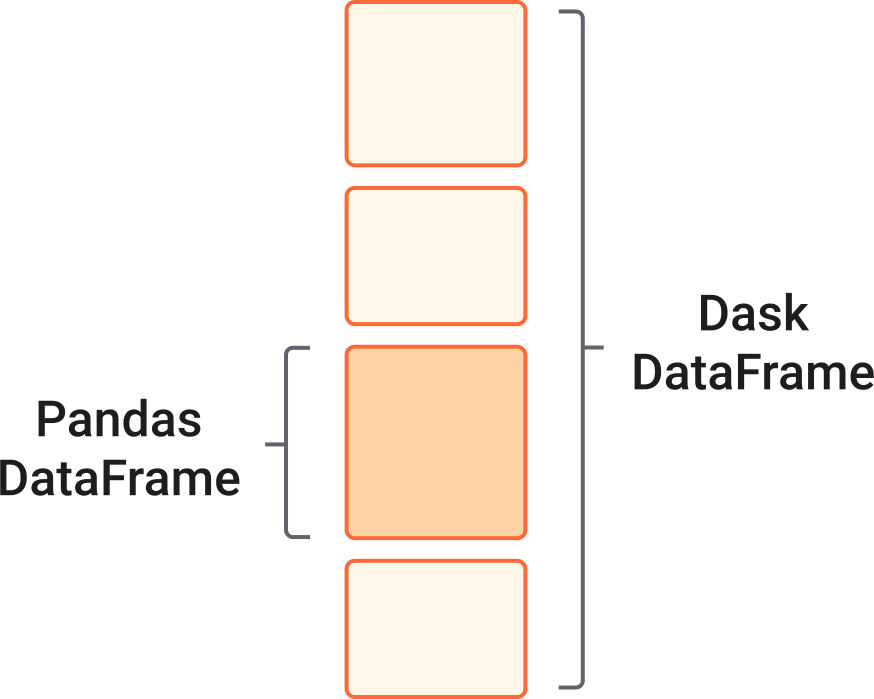

In [5]:
# Structure of a Dask dataframe
SVG(filename='images/dask-dataframe.svg')

In [6]:
# Read in the data and print out the first few rows in the Dask dataframe
df = dd.read_parquet('/domino/datasets/local/Dask/yellow_tripdata_2022-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [7]:
# Print the shape of the data frame. Since Dask is lazy it only outputs the number of columns
df.shape

(Delayed('int-0c1f5f24-5e12-4cfb-8850-8840e47da077'), 19)

In [8]:
# Make a non lazy call to get the number of rows 
print(f"No. of rows : {df.shape[0].compute()}\nNo. of columns : {df.shape[1]}")

No. of rows : 2463931
No. of columns : 19


In [9]:
# Call the function that groups the dataframe by payment_type
jan_payments = payment_by_type(df)

In [10]:
# Note that the return type is a regular Pandas object
type(jan_payments)

pandas.core.series.Series

<AxesSubplot:title={'center':'Jan Payments'}, xlabel='payment_type'>

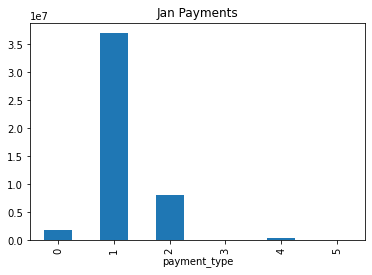

In [11]:
# Plot a histogram of the different payment types for the January data set
jan_payments.plot(kind='bar', title='Jan Payments')

In [12]:
# Load the datasets for the months of February and March as well and group them by payment_type

feb_df = dd.read_parquet('/domino/datasets/local/Dask/yellow_tripdata_2022-02.parquet')
march_df = dd.read_parquet('/domino/datasets/local/Dask/yellow_tripdata_2022-03.parquet')
print(f"No. of rows : {feb_df.shape[0].compute()}\nNo. of columns : {feb_df.shape[1]}")
print(f"No. of rows : {march_df.shape[0].compute()}\nNo. of columns : {march_df.shape[1]}")

df.persist()
feb_df.persist()
march_df.persist()

feb_payments = payment_by_type(feb_df)
march_payments = payment_by_type(march_df)

No. of rows : 2979431
No. of columns : 19
No. of rows : 3627882
No. of columns : 19


In [13]:
# Concat all the separate monthwise dataframes into 1 dataframe. As the returned objects are Pandas objects the Pandas
# function can be called directly
qtr_payments = pd.concat([jan_payments, feb_payments, march_payments], axis=1)
qtr_payments

,total_amount,total_amount,total_amount
payment_type,,,
0,1717181.71,2480313.06,3137868.05
1,36992734.94,46418179.62,59710045.98
2,8102956.31,9181362.01,11862739.95
3,90890.33,99405.01,111670.09
4,328230.14,-87046.06,-111028.07
5,11.80,0.00,0.00


In [14]:
# Drop some rows that have data that is not relevant to the problem
qtr_payments.drop([4,5], inplace=True)

In [15]:
# Rename the columns in the data frame
qtr_payments.columns =['jan_amount', 'feb_amount', 'march_amount']

In [16]:
# Print out the dataframe
qtr_payments

,jan_amount,feb_amount,march_amount
payment_type,,,
0,1717181.71,2480313.06,3137868.05
1,36992734.94,46418179.62,59710045.98
2,8102956.31,9181362.01,11862739.95
3,90890.33,99405.01,111670.09


<AxesSubplot:>

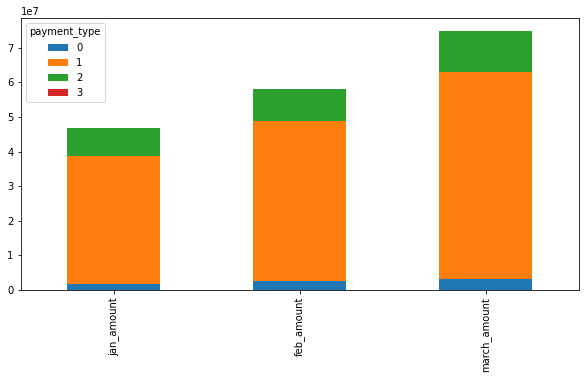

In [17]:
# Plot a stacked bar chart with the different payment types for the months in the quarter
qtr_t = qtr_payments.T
qtr_t.plot(kind='bar', stacked=True, figsize=(10,5))

In [18]:
# Create a Dask dataframe that has all the data from the different monthly Dask dataframes
qtr_df = dd.concat([df, feb_df, march_df]) 
print(f"No. of rows : {qtr_df.shape[0].compute()}\nNo. of columns : {qtr_df.shape[1]}")

No. of rows : 9071244
No. of columns : 19


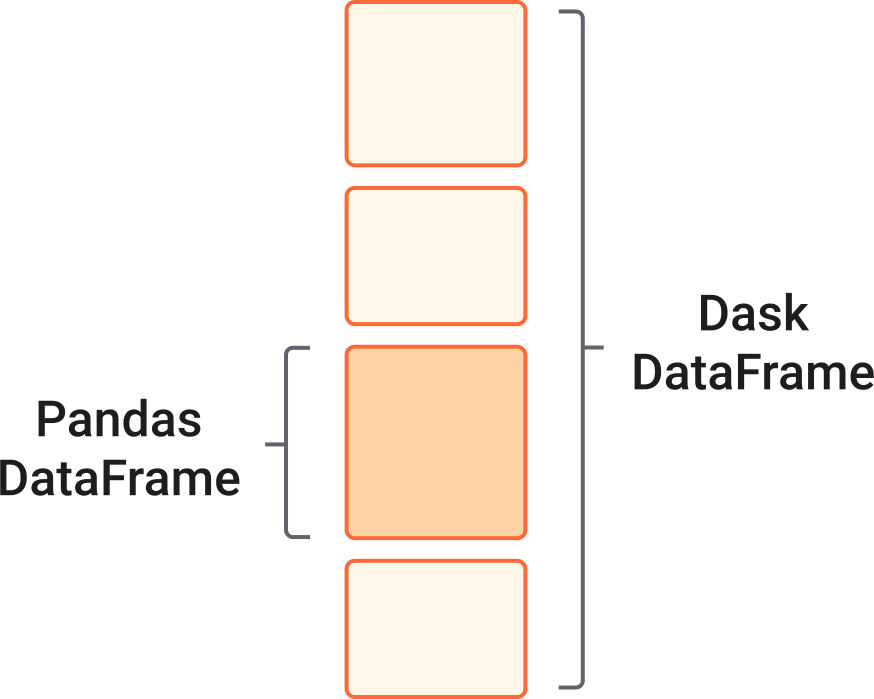

In [19]:
SVG(filename='images/dask-dataframe.svg')

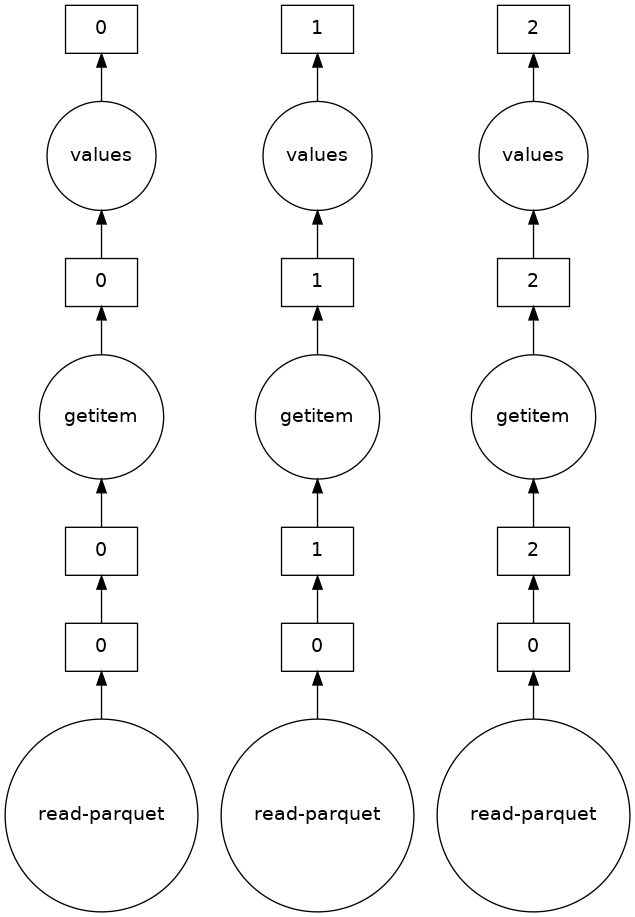

In [20]:
# Select a column from the Dask dataframe and view the Dask DAG/task graph for the operation
trip_distance = qtr_df['trip_distance'].to_dask_array(lengths=True, meta=None)
trip_distance.visualize()

In [21]:
# Get summary statistics on the Dask dataframe using the bullt in Dask functions
trip_dist_std = da.nanstd(trip_distance, axis=0, dtype='float64')
trip_dist_median = da.median(trip_distance, axis=0)
trip_dist_max = da.nanmax(trip_distance,axis=0)
trip_dist_min = da.nanmin(trip_distance,axis=0)
trip_dist_max.visualize()
dask.compute(trip_dist_median, trip_dist_std, trip_dist_max, trip_dist_min)

(1.8, 588.9150804822376, 348798.53, 0.0)

In [22]:
# Compute a histogram/1-d distribution using the built in Dask array function
hist, bins = da.histogram(trip_distance, bins=30, range=[trip_dist_min, trip_dist_max]) 
# Visualize how the histogram is stored internally, this is executed lazily so the results are not available
hist

dask.array<sum-aggregate, shape=(30,), dtype=int64, chunksize=(30,), chunktype=numpy.ndarray>

[9071016      13      17      20      14      13      24      22      27
      16      14       3      11       4       5       4       2       2
       2       1       1       4       2       2       1       0       1
       2       0       1]


<BarContainer object of 30 artists>

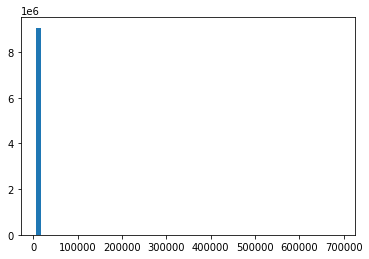

In [23]:
# Execute the lazy computation using the compute() call and plot the histogram
hist_c = hist.compute()
print(hist_c)
plt_bins = bins.compute()
# plot results
x = (plt_bins[1:] + plt_bins[:-1])
width = np.diff(plt_bins)
plt.bar(x, hist_c, width)

In [24]:
# Run a subset operation to remove outliers
clean_trip_dist = trip_distance[dask.array.absolute(trip_distance - trip_dist_median) < trip_dist_median]

[6961231       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0]


<BarContainer object of 30 artists>

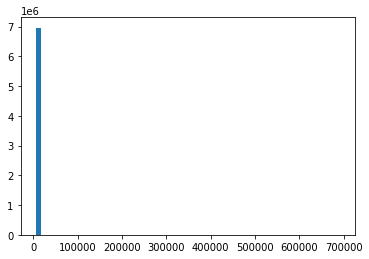

In [25]:
# Compute the histogram using the dataset that has the outliers removed
hist, bins = da.histogram(clean_trip_dist, bins=30, range=[trip_dist_min, trip_dist_max]) 
hist_c = hist.compute()
print(hist_c)
# plot results
plt_bins = bins.compute()
x = (plt_bins[1:] + plt_bins[:-1])
width = np.diff(plt_bins)
plt.bar(x, hist_c, width)

[ 39857  92455 285832 539441 650311 540596 678765 611577 536566 519819
 372131 377733 351913 291842 206309 235533 195938 166118 158824 109671
      0      0      0      0      0      0      0      0      0      0]


<BarContainer object of 30 artists>

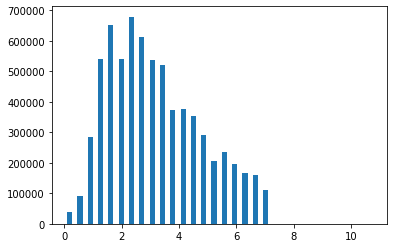

In [26]:
# Recompute the histogram by specifying the range of bins in the built in histogram function
hist, bins = da.histogram(clean_trip_dist, bins=30, range=[trip_dist_min, 3* trip_dist_median]) 
hist_c = hist.compute()
print(hist_c)
# plot results
plt_bins = bins.compute()
x = (plt_bins[1:] + plt_bins[:-1])
width = np.diff(plt_bins)
plt.bar(x, hist_c, width)

In [27]:
# Sum up the counts in the each of the bins, this matches the total number of rows in the dataframe
# with the outliers removed
sum(hist_c)

6961231

In [28]:
# Disconnect from the Dask cluster
client.close()